In [1]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from torch.utils.data import DataLoader, Dataset

# Preprocessing Steps Applied

In [2]:
def preprocess_data(data: list) -> list:
    sentences = []
    for sentence_data in data:
        sentence_id = sentence_data["sentence_id"]
        sentence = sentence_data["sentence"]
        tokens = sentence.split()

        for i in range(len(tokens)):
            while tokens[i] and not tokens[i][0].isalnum():
                tokens[i] = tokens[i][1:]
            while tokens[i] and not tokens[i][-1].isalnum():
                tokens[i] = tokens[i][:-1]

        while "" in tokens:
            tokens.remove("")

        len_prefix = []
        new_token = True
        for i in range(len(sentence)):
            if sentence[i] == " ":
                new_token = True
            elif new_token:
                len_prefix.append(i)
                new_token = False
        # len_prefix.append(len(sentence))

        for term in sentence_data["aspect_terms"]:
            term_start = int(term["from"])
            term_end = int(term["to"])
            polarity = term["polarity"]

            low = 0
            high = len(len_prefix)
            while low < high:
                mid = (low + high) // 2
                if len_prefix[mid] < term_start:
                    low = mid + 1
                else:
                    high = mid

            token_idx = low

            if token_idx == len(len_prefix):
                token_idx -= 1

            first_token = term["term"].split()[0]

            while first_token and not first_token[0].isalnum():
                first_token = first_token[1:]
            while first_token and not first_token[-1].isalnum():
                first_token = first_token[:-1]

            while token_idx >= len(tokens) or first_token not in tokens[token_idx]:
                token_idx -= 1
                if token_idx < 0:
                    print("OOPS There has been some error:", sentence)
                    print("Term:", term["term"])
                    print("Tokens:", tokens)
                    break

            sentences.append({
                "tokens": tokens,
                "polarity": polarity,
                "aspect_term": term["term"].split(),
                "index": token_idx
            })

    return sentences

In [3]:
with open("/kaggle/input/nlp-dataset-2/train.json") as f:
    train_data = json.load(f)

with open("/kaggle/input/nlp-dataset-2/val.json") as f:
    val_data = json.load(f)

val_data = preprocess_data(val_data)
train_data = preprocess_data(train_data)

with open("train_task_2.json", "w") as f:
    json.dump(train_data, f, indent=4)

with open("val_task_2.json", "w") as f:
    json.dump(val_data, f, indent=4)

# Model Training

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import json
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder

In [5]:
BERT_MODEL = "bert-base-uncased"
HIDDEN_DIM = 128
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.0001

def load_data(file_path):
    with open(file_path, "r") as f:
        return json.load(f)

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

label_encoder = LabelEncoder()
labels = ["positive", "negative", "neutral", "conflict"]
label_encoder.fit(labels)

def encode_data(data):
    encoded_data = []
    for sample in data:
        sentence = " ".join(sample["tokens"])
        aspect = " ".join(sample["aspect_term"])

        sentence_encoding = tokenizer(sentence, padding="max_length", truncation=True, 
                                      max_length=128, return_tensors="pt")
        aspect_encoding = tokenizer(aspect, padding="max_length", truncation=True, 
                                    max_length=16, return_tensors="pt")
        label = label_encoder.transform([sample["polarity"]])[0]

        encoded_data.append((sentence_encoding["input_ids"].squeeze(0),
                             sentence_encoding["attention_mask"].squeeze(0),
                             aspect_encoding["input_ids"].squeeze(0),
                             aspect_encoding["attention_mask"].squeeze(0),
                             label))
    return encoded_data

def collate_fn(batch):
    input_ids, attention_masks, aspect_ids, aspect_masks, labels = zip(*batch)
    return (torch.stack(input_ids), torch.stack(attention_masks),
            torch.stack(aspect_ids), torch.stack(aspect_masks),
            torch.tensor(labels))

class Enhanced_LSTM(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super(Enhanced_LSTM, self).__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL)

        self.lstm_left = nn.LSTM(self.bert.config.hidden_size, hidden_dim, 
                                 num_layers=3, batch_first=True, bidirectional=True)
        self.lstm_right = nn.LSTM(self.bert.config.hidden_size, hidden_dim, 
                                  num_layers=3, batch_first=True, bidirectional=True)

        self.aspect_fc = nn.Linear(self.bert.config.hidden_size, hidden_dim * 4)

        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim * 4, num_heads=2, batch_first=True)

        self.residual_fc = nn.Linear(hidden_dim * 4, hidden_dim * 4)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 4)

        self.highway = nn.Linear(hidden_dim * 4, hidden_dim * 4)
        self.gate = nn.Linear(hidden_dim * 4, hidden_dim * 4)

        self.fc = nn.Linear(hidden_dim * 4, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, attention_mask, aspect_ids, aspect_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        aspect_output = self.bert(input_ids=aspect_ids, attention_mask=aspect_mask)

        lstm_input = bert_output.last_hidden_state
        aspect_repr = torch.mean(aspect_output.last_hidden_state, dim=1)
        aspect_vec = self.aspect_fc(aspect_repr).unsqueeze(1)

        lstm_out_left, _ = self.lstm_left(lstm_input)
        lstm_out_right, _ = self.lstm_right(lstm_input)

        combined_lstm_out = torch.cat((lstm_out_left, lstm_out_right), dim=-1)

        aspect_connected = combined_lstm_out + aspect_vec

        attention_output, _ = self.attention(aspect_connected, aspect_connected, aspect_connected)

        residual_output = self.residual_fc(attention_output) + aspect_connected
        normalized_output = self.batch_norm(residual_output.permute(0, 2, 1)).permute(0, 2, 1)

        highway_gate = torch.sigmoid(self.gate(normalized_output))
        highway_output = highway_gate * torch.relu(self.highway(normalized_output)) + (1 - highway_gate) * normalized_output

        pooled_output = torch.mean(highway_output, dim=1)
        output = self.fc(self.dropout(pooled_output))
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Enhanced_LSTM(HIDDEN_DIM, len(labels)).to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Using 2 GPUs


New best model saved with validation accuracy: 0.6199
Epoch 1: Train Loss=0.9624, Train Acc=0.6211, Val Loss=0.9216, Val Acc=0.6199
New best model saved with validation accuracy: 0.7062
Epoch 2: Train Loss=0.6575, Train Acc=0.7562, Val Loss=0.8166, Val Acc=0.7062
Epoch 3: Train Loss=0.5117, Train Acc=0.8153, Val Loss=0.8905, Val Acc=0.6873
New best model saved with validation accuracy: 0.7143
Epoch 4: Train Loss=0.4331, Train Acc=0.8399, Val Loss=0.8680, Val Acc=0.7143
Epoch 5: Train Loss=0.3505, Train Acc=0.8723, Val Loss=0.8935, Val Acc=0.6900
Epoch 6: Train Loss=0.3028, Train Acc=0.8889, Val Loss=0.9049, Val Acc=0.6712
Epoch 7: Train Loss=0.2464, Train Acc=0.9085, Val Loss=0.9258, Val Acc=0.7062
Epoch 8: Train Loss=0.2194, Train Acc=0.9179, Val Loss=1.1051, Val Acc=0.6604
Epoch 9: Train Loss=0.2025, Train Acc=0.9250, Val Loss=1.0675, Val Acc=0.6819
Epoch 10: Train Loss=0.1795, Train Acc=0.9321, Val Loss=1.1823, Val Acc=0.6765


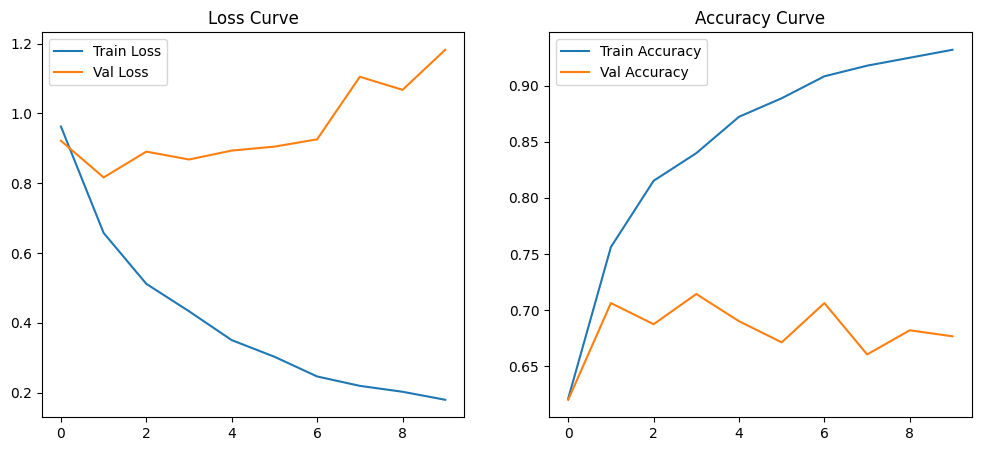

In [11]:
train_data = load_data("train_task_2.json")
val_data = load_data("val_task_2.json")

train_encoded = encode_data(train_data)
val_encoded = encode_data(val_data)

train_loader = data.DataLoader(train_encoded, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = data.DataLoader(val_encoded, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def train(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_acc, val_acc, train_loss, val_loss = [], [], [], []
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0
        for batch in train_loader:
            input_ids, attention_mask, aspect_ids, aspect_mask, labels = [b.to(device) for b in batch]
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, aspect_ids, aspect_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
        train_accuracy = correct / len(train_loader.dataset)
        train_loss.append(total_loss / len(train_loader))
        train_acc.append(train_accuracy)

        # Validation
        model.eval()
        correct_val, val_loss_epoch = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, aspect_ids, aspect_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids, attention_mask, aspect_ids, aspect_mask)
                loss = criterion(outputs, labels)
                val_loss_epoch += loss.item()
                correct_val += (outputs.argmax(dim=1) == labels).sum().item()
        val_accuracy = correct_val / len(val_loader.dataset)
        val_loss.append(val_loss_epoch / len(val_loader))
        val_acc.append(val_accuracy)

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), "best_enhanced_lstm_bert.pth")
            print(f"New best model saved with validation accuracy: {val_accuracy:.4f}")

        print(f"Epoch {epoch+1}: Train Loss={train_loss[-1]:.4f}, Train Acc={train_acc[-1]:.4f}, Val Loss={val_loss[-1]:.4f}, Val Acc={val_acc[-1]:.4f}")

    return train_loss, val_loss, train_acc, val_acc

train_loss, val_loss, train_acc, val_acc = train(model, train_loader, val_loader, criterion, optimizer, EPOCHS)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

In [ ]:
def get_inference(file_name):
    with open(file_name) as f:
        test_data = json.load(f)
    test_data = preprocess_data(test_data)

    test_encoded = encode_data(test_data)
    test_loader = data.DataLoader(test_encoded, batch_size=64, shuffle=False, collate_fn=collate_fn)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.load_state_dict(torch.load("best_enhanced_lstm_bert.pth", map_location=device, weights_only=True))

    model.eval()
    correct = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, aspect_ids, aspect_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask, aspect_ids, aspect_mask)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
    accuracy = correct / len(test_loader.dataset)
    return accuracy

test_accuracy = get_inference("/kaggle/input/nlp-dataset-2/val.json")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7143


# Additional Tasks (Transformer)

In [6]:
class TransformerDataset(Dataset):
    def __init__(self, sentences: list, tokenizer):
        self.data = sentences
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sentence = self.data[idx]
        tokens = self.tokenizer(" ".join(sentence["tokens"]), truncation=True, padding="max_length", max_length=128)
        aspect_tokens = self.tokenizer(" ".join(sentence["aspect_term"]), truncation=True, padding="max_length", max_length=16)

        idx = sentence["index"]

        label = sentence["polarity"]
        if label == "conflict":
            label = 3
        elif label == "positive":
            label = 2
        elif label == "neutral":
            label = 1
        else:
            label = 0

        return {
            "tokens": tokens,
            "aspect_tokens": aspect_tokens,
            "label": torch.tensor(label),
            "idx": torch.tensor(idx)
        }

In [7]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel, BartTokenizer, BartModel, RobertaTokenizer, RobertaModel, AdamW
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# BERT ABSA Model Finetuning

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Training Epoch 1: 100%|██████████| 93/93 [01:10<00:00,  1.31it/s]


Epoch 1 average training loss: 1.0044


Validation Epoch 1: 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]


Epoch 1/3 Training Loss: 1.0044, Training Accuracy: 0.5691, Validation Loss: 0.9062, Validation Accuracy: 0.6469


Training Epoch 2: 100%|██████████| 93/93 [01:10<00:00,  1.31it/s]


Epoch 2 average training loss: 0.6933


Validation Epoch 2: 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]


Epoch 2/3 Training Loss: 0.6933, Training Accuracy: 0.7369, Validation Loss: 0.7504, Validation Accuracy: 0.7035


Training Epoch 3: 100%|██████████| 93/93 [01:10<00:00,  1.32it/s]


Epoch 3 average training loss: 0.5478


Validation Epoch 3: 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]


Epoch 3/3 Training Loss: 0.5478, Training Accuracy: 0.7991, Validation Loss: 0.7329, Validation Accuracy: 0.7116


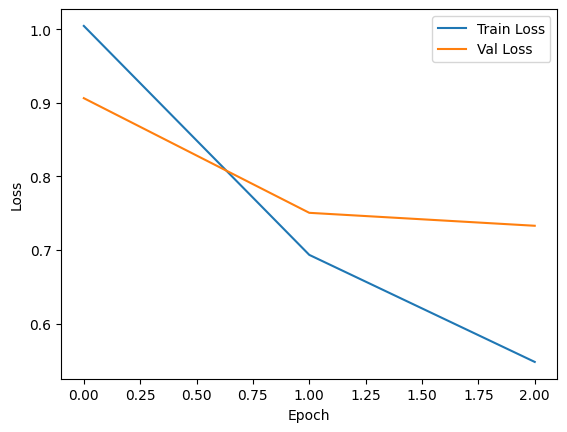

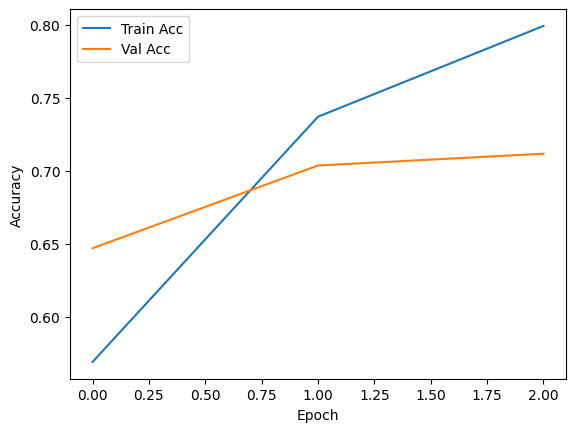

In [10]:
def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item["tokens"]["input_ids"]) for item in batch])
    attention_mask = torch.stack([torch.tensor(item["tokens"]["attention_mask"]) for item in batch])
    token_type_ids = torch.stack([torch.tensor(item["tokens"]["token_type_ids"]) for item in batch])

    aspect_input_ids = torch.stack([torch.tensor(item["aspect_tokens"]["input_ids"]) for item in batch])
    aspect_attention_mask = torch.stack([torch.tensor(item["aspect_tokens"]["attention_mask"]) for item in batch])
    aspect_token_type_ids = torch.stack([torch.tensor(item["aspect_tokens"]["token_type_ids"]) for item in batch])

    labels = torch.stack([item["label"] for item in batch])
    idxs = torch.stack([item["idx"] for item in batch])
    
    batch_tokens = {
        "input_ids": input_ids, 
        "attention_mask": attention_mask,
        "token_type_ids": token_type_ids,
        "aspect_input_ids": aspect_input_ids,
        "aspect_attention_mask": aspect_attention_mask,
        "aspect_token_type_ids": aspect_token_type_ids
    }

    return batch_tokens, labels, idxs

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
transformer_train_dataset = TransformerDataset(train_data, tokenizer)
transformer_val_dataset = TransformerDataset(val_data, tokenizer)

train_loader = DataLoader(transformer_train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, pin_memory=True)
val_loader = DataLoader(transformer_val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, pin_memory=True)

class BertModelABSA(nn.Module):
    def __init__(self, num_classes):
        super(BertModelABSA, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(self.bert.config.hidden_size * 2, num_classes)
        
    def forward(self, input_ids, attention_mask, token_type_ids, aspect_input_ids, aspect_attention_mask, aspect_token_type_ids, labels=None):
        sentence_outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        sentence_embedding = sentence_outputs.pooler_output

        aspect_outputs = self.bert(
            input_ids=aspect_input_ids,
            attention_mask=aspect_attention_mask,
            token_type_ids=aspect_token_type_ids
        )
        aspect_embedding = aspect_outputs.pooler_output

        combined = torch.cat([sentence_embedding, aspect_embedding], dim=1)
        outputs = self.fc(combined)

        if labels is not None:
            loss = nn.CrossEntropyLoss()(outputs, labels)
            return (loss, outputs)
        
        return outputs

model = BertModelABSA(num_classes=4)
model.to(device)

# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs")
#     model = nn.DataParallel(model)

optimizer = AdamW(model.parameters(), lr=2e-5)

num_epochs = 3

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for batch_tokens, labels, _ in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        for key in batch_tokens:
            batch_tokens[key] = batch_tokens[key].to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(**batch_tokens, labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total += labels.size(0)
        correct += (torch.argmax(outputs[1], dim=-1) == labels).sum().item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_acc = correct / total
    train_accs.append(train_acc)
    print(f"Epoch {epoch+1} average training loss: {avg_train_loss:.4f}")
    
    model.eval()
    total_val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for batch_tokens, labels, _ in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            for key in batch_tokens:
                batch_tokens[key] = batch_tokens[key].to(device)
            labels = labels.to(device)
            
            outputs = model(**batch_tokens, labels=labels)
            loss = outputs[0]
            total_val_loss += loss.item()
            
            logits = outputs[1]
            predictions = torch.argmax(logits, dim=-1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
    
    avg_val_loss = total_val_loss / len(val_loader)
    accuracy = correct_predictions / total_predictions
    val_losses.append(avg_val_loss)
    val_accs.append(accuracy)
    print(f"Epoch {epoch+1}/{num_epochs} Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")
    
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# BART ABSA Model Finetuning

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1: 100%|██████████| 93/93 [04:22<00:00,  2.83s/it]


Epoch 1 average training loss: 0.8701


Validation Epoch 1: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


Epoch 1/3 Training Loss: 0.8701, Training Accuracy: 0.6660, Validation Loss: 0.7975, Validation Accuracy: 0.6873


Training Epoch 2: 100%|██████████| 93/93 [04:32<00:00,  2.93s/it]


Epoch 2 average training loss: 0.6204


Validation Epoch 2: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


Epoch 2/3 Training Loss: 0.6204, Training Accuracy: 0.7680, Validation Loss: 0.7059, Validation Accuracy: 0.7251


Training Epoch 3: 100%|██████████| 93/93 [04:32<00:00,  2.93s/it]


Epoch 3 average training loss: 0.5442


Validation Epoch 3: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


Epoch 3/3 Training Loss: 0.5442, Training Accuracy: 0.7933, Validation Loss: 0.7350, Validation Accuracy: 0.7278


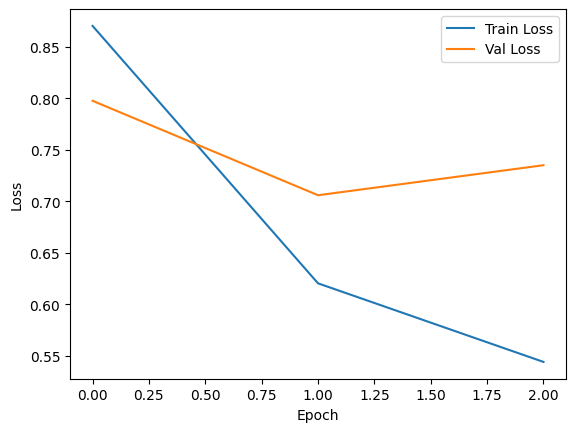

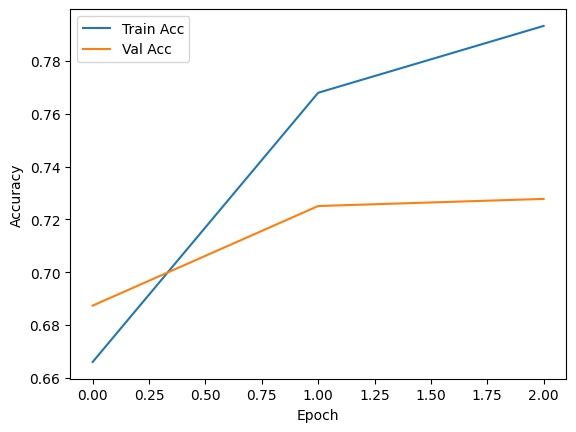

In [8]:
def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item["tokens"]["input_ids"]) for item in batch])
    attention_mask = torch.stack([torch.tensor(item["tokens"]["attention_mask"]) for item in batch])

    aspect_input_ids = torch.stack([torch.tensor(item["aspect_tokens"]["input_ids"]) for item in batch])
    aspect_attention_mask = torch.stack([torch.tensor(item["aspect_tokens"]["attention_mask"]) for item in batch])

    labels = torch.stack([item["label"] for item in batch])
    idxs = torch.stack([item["idx"] for item in batch])
    
    batch_tokens = {
        "input_ids": input_ids, 
        "attention_mask": attention_mask,
        "aspect_input_ids": aspect_input_ids,
        "aspect_attention_mask": aspect_attention_mask,
    }

    return batch_tokens, labels, idxs

tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
transformer_train_dataset = TransformerDataset(train_data, tokenizer)
transformer_val_dataset = TransformerDataset(val_data, tokenizer)

train_loader = DataLoader(transformer_train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, pin_memory=True)
val_loader = DataLoader(transformer_val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, pin_memory=True)

class BartModelABSA(nn.Module):
    def __init__(self, num_classes):
        super(BartModelABSA, self).__init__()
        self.bart = BartModel.from_pretrained("facebook/bart-large")
        self.fc = nn.Linear(self.bart.config.d_model * 2, num_classes)

    def forward(self, input_ids, attention_mask, aspect_input_ids, aspect_attention_mask, labels=None, **kwargs):
        sentence_outputs = self.bart(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        sentence_embedding = sentence_outputs.last_hidden_state[:, 0, :]
        
        aspect_outputs = self.bart(
            input_ids=aspect_input_ids,
            attention_mask=aspect_attention_mask
        )
        aspect_embedding = aspect_outputs.last_hidden_state[:, 0, :]
        
        combined = torch.cat([sentence_embedding, aspect_embedding], dim=1)
        logits = self.fc(combined)
        
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
            return (loss, logits)
        
        return logits

model = BartModelABSA(num_classes=4)
model.to(device)

# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs")
#     model = nn.DataParallel(model)

optimizer = AdamW(model.parameters(), lr=2e-5)

num_epochs = 3

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for batch_tokens, labels, _ in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        for key in batch_tokens:
            batch_tokens[key] = batch_tokens[key].to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(**batch_tokens, labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total += labels.size(0)
        correct += (torch.argmax(outputs[1], dim=-1) == labels).sum().item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_acc = correct / total
    train_accs.append(train_acc)
    print(f"Epoch {epoch+1} average training loss: {avg_train_loss:.4f}")
    
    # Validation phase
    model.eval()
    total_val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for batch_tokens, labels, _ in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            for key in batch_tokens:
                batch_tokens[key] = batch_tokens[key].to(device)
            labels = labels.to(device)
            
            outputs = model(**batch_tokens, labels=labels)
            loss = outputs[0]
            total_val_loss += loss.item()
            
            logits = outputs[1]
            predictions = torch.argmax(logits, dim=-1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
    
    avg_val_loss = total_val_loss / len(val_loader)
    accuracy = correct_predictions / total_predictions
    val_losses.append(avg_val_loss)
    val_accs.append(accuracy)
    print(f"Epoch {epoch+1}/{num_epochs} Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")
    
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# RoBERTa ABSA Model Finetuning

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1: 100%|██████████| 93/93 [01:10<00:00,  1.32it/s]


Epoch 1 average training loss: 0.8565


Validation Epoch 1: 100%|██████████| 12/12 [00:02<00:00,  4.30it/s]


Epoch 1/3 Training Loss: 0.8565, Training Accuracy: 0.6518, Validation Loss: 0.7550, Validation Accuracy: 0.6819


Training Epoch 2: 100%|██████████| 93/93 [01:10<00:00,  1.32it/s]


Epoch 2 average training loss: 0.6005


Validation Epoch 2: 100%|██████████| 12/12 [00:02<00:00,  4.30it/s]


Epoch 2/3 Training Loss: 0.6005, Training Accuracy: 0.7778, Validation Loss: 0.7463, Validation Accuracy: 0.6712


Training Epoch 3: 100%|██████████| 93/93 [01:09<00:00,  1.33it/s]


Epoch 3 average training loss: 0.5001


Validation Epoch 3: 100%|██████████| 12/12 [00:02<00:00,  4.31it/s]


Epoch 3/3 Training Loss: 0.5001, Training Accuracy: 0.8034, Validation Loss: 0.8003, Validation Accuracy: 0.7008


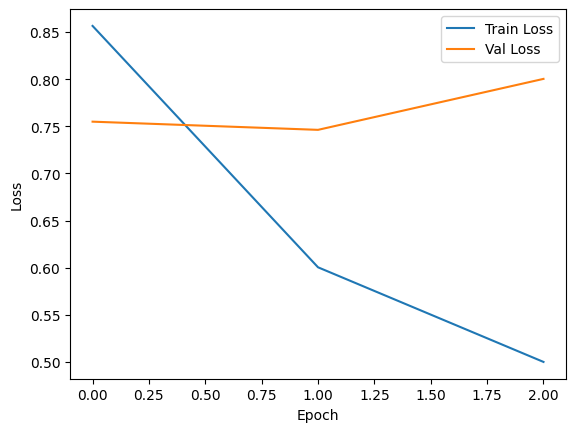

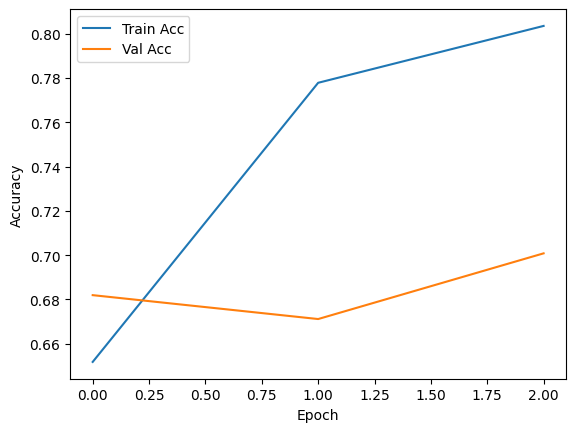

In [9]:
def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item["tokens"]["input_ids"]) for item in batch])
    attention_mask = torch.stack([torch.tensor(item["tokens"]["attention_mask"]) for item in batch])

    aspect_input_ids = torch.stack([torch.tensor(item["aspect_tokens"]["input_ids"]) for item in batch])
    aspect_attention_mask = torch.stack([torch.tensor(item["aspect_tokens"]["attention_mask"]) for item in batch])

    labels = torch.stack([item["label"] for item in batch])
    idxs = torch.stack([item["idx"] for item in batch])
    
    batch_tokens = {
        "input_ids": input_ids, 
        "attention_mask": attention_mask,
        "aspect_input_ids": aspect_input_ids,
        "aspect_attention_mask": aspect_attention_mask
    }

    return batch_tokens, labels, idxs

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
transformer_train_dataset = TransformerDataset(train_data, tokenizer)
transformer_val_dataset = TransformerDataset(val_data, tokenizer)

train_loader = DataLoader(transformer_train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, pin_memory=True)
val_loader = DataLoader(transformer_val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, pin_memory=True)

class RobertaModelABSA(nn.Module):
    def __init__(self, num_classes):
        super(RobertaModelABSA, self).__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.fc = nn.Linear(self.roberta.config.hidden_size * 2, num_classes)
        

    def forward(self, input_ids, attention_mask, aspect_input_ids, aspect_attention_mask, labels=None):
        sentence_outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        sentence_embedding = sentence_outputs.last_hidden_state[:, 0, :]

        aspect_outputs = self.roberta(
            input_ids=aspect_input_ids,
            attention_mask=aspect_attention_mask
        )
        aspect_embedding = aspect_outputs.last_hidden_state[:, 0, :]

        combined = torch.cat([sentence_embedding, aspect_embedding], dim=1)
        outputs = self.fc(combined)

        if labels is not None:
            loss = nn.CrossEntropyLoss()(outputs, labels)
            return (loss, outputs)
        
        return outputs

model = RobertaModelABSA(num_classes=4)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

num_epochs = 3

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for batch_tokens, labels, _ in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        for key in batch_tokens:
            batch_tokens[key] = batch_tokens[key].to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(**batch_tokens, labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total += labels.size(0)
        correct += (torch.argmax(outputs[1], dim=-1) == labels).sum().item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_acc = correct / total
    train_accs.append(train_acc)
    print(f"Epoch {epoch+1} average training loss: {avg_train_loss:.4f}")
    
    model.eval()
    total_val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for batch_tokens, labels, _ in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            for key in batch_tokens:
                batch_tokens[key] = batch_tokens[key].to(device)
            labels = labels.to(device)
            
            outputs = model(**batch_tokens, labels=labels)
            loss = outputs[0]
            total_val_loss += loss.item()
            
            logits = outputs[1]
            predictions = torch.argmax(logits, dim=-1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
    
    avg_val_loss = total_val_loss / len(val_loader)
    accuracy = correct_predictions / total_predictions
    val_losses.append(avg_val_loss)
    val_accs.append(accuracy)
    print(f"Epoch {epoch+1}/{num_epochs} Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")
    
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
